Checking if our halfmass radii seem reasonable by overplotting them on a image

In [1]:
import pynbody
import numpy as np 
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt

import glob

import sys 
sys.path.insert(0, '/home/jw1624/H1-merian/util/')
from util import util

In [2]:
def halfMassRadius_bisect(sim, outerR, acc, maxiter=100000):
    innerLim = 0.0
    outerLim = outerR

    pRadii = np.array(sim.s['r'].in_units('kpc'))
    pMass = np.array(sim.s['mass'])
    mTot = sum(pMass)

    r = outerR/2
    hm = sum(pMass[pRadii < r])
    n=0
    while(hm < (0.5-acc)*mTot or hm > (0.5+acc)*mTot):
        if hm > 0.5*mTot: # too big, decrease r
            outerLim = r
            r = innerLim + (outerLim-innerLim)/2
        elif hm < 0.5*mTot: # too small increase r
            innerLim = r
            r = innerLim + (outerLim-innerLim)/2
        hm = sum(pMass[pRadii < r])

        n += 1
        if n>maxiter:
            return -1
            break

    return r

## Images

In [3]:
# image function
def makeStarImage(hID, ts=0, width=20, sidm=0):
    baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
    galDir = baseDir+ '/r' + str(hID)+'.romulus25.3072g1HsbBH'

    timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
    timesteps.sort(reverse=True)

    f = glob.glob(timesteps[ts]+'/r*.00'+timesteps[ts][-4:])[0]
    
    v_disp = -1

    fig, ax = plt.subplots(1,1, figsize=(8,8), facecolor='w')

    s = pynbody.load(f)
    s.physical_units()

    h = s.halos()
    v_disp = np.median(np.array(h[1].g['v_disp']))

    # center on the largest halo and align the disk
    pynbody.analysis.angmom.faceon(h[1])
    im = pynbody.plot.stars.render(s, width=str(width)+' kpc', plot=False, ret_im=True)
    
    pxlwid = len(im[0])
    pxlKpcRatio = pxlwid/width
    
    tag = 'CDM'
    if sidm: tag = 'SIDM'
    plt.title('r'+str(hID) + ' '+tag, fontsize=20, fontfamily='serif')

    # find radius and plot as circle
    hmr = halfMassRadius_bisect(s, width, 0.01)
    print(hmr)
    
    circle = plt.Circle((pxlwid/2,pxlwid/2), hmr*pxlKpcRatio, edgecolor='g', linewidth=3, fill=False)
    
    ax.imshow(im)
    ax.add_patch(circle)
    
    plt.tight_layout()

In [4]:
currentGals = util.getGalaxies()[0]

1.1328125


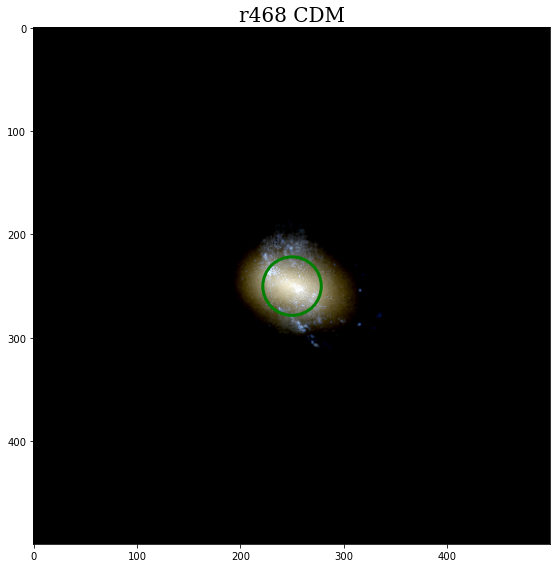

In [7]:
makeStarImage(currentGals[2], 0)